# Forecasting electricity carbon intensity using SARIMAX

In this project, we **forecast the hourly carbon intensity of electricity in France up to 48 hours ahead** based on data hourly data over 6 years (from 2016).

The dataset used here was retrieved using the API of **electricitymap.org** (https://electricitymap.org). Electricitymap provides real-time visualizations about the origin of the electricity consumed across 50+ countries. In particular, it provides an hourly view of the carbon intensity of electricity in grams of CO2-equivalent per kWh electricity consumed (gCO2e/kWh).


## Import data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [5]:
df = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/electricity_map_france.csv', parse_dates=['datetime'], index_col=['datetime'])
df = df['2016':]
df.fillna(method='bfill', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32691 entries, 2016-01-01 00:00:00+00:00 to 2019-09-26 08:00:00+00:00
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   timestamp                                     32691 non-null  int64  
 1   zone_name                                     32691 non-null  object 
 2   carbon_intensity_avg                          32691 non-null  float64
 3   carbon_intensity_production_avg               32691 non-null  float64
 4   carbon_intensity_discharge_avg                32691 non-null  float64
 5   carbon_intensity_import_avg                   32691 non-null  float64
 6   carbon_rate_avg                               32691 non-null  float64
 7   total_production_avg                          32691 non-null  float64
 8   total_storage_avg                             32691 non-null  float64
 9   total_discharg

## Train-test split

In [8]:
train_size = 0.7
index = round(train_size*df.shape[0])
df_train = df.iloc[:index]
df_test = df.iloc[index+1:]

y = df['carbon_intensity_avg']
y_train = df_train['carbon_intensity_avg']
y_test = df_test['carbon_intensity_avg']

**Add exogenous features** <br>
An exogenous feature is one whose value is determined outside the model and is imposed on the model. In other words, variables that affect a model without being affected by it. Source
[**towardsdatascience.com**](https://towardsdatascience.com/)

In [9]:
exog = df['latest_forecasted_price_avg']
exog_train = df_train['latest_forecasted_price_avg']
exog_test = df_test['latest_forecasted_price_avg']

## Visualize the data
Including autocorrelation and partial autocorrelation

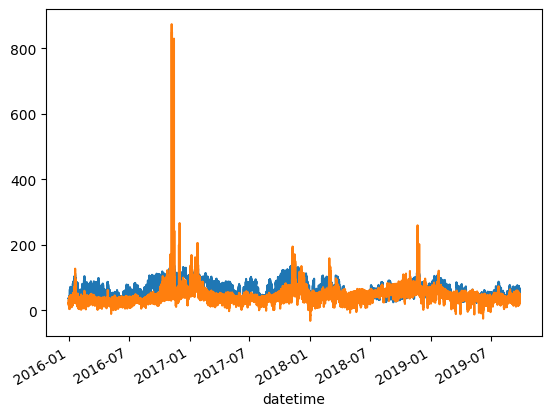

In [13]:
%matplotlib widget
%matplotlib inline

y.plot()
df.latest_forecasted_price_avg.plot();

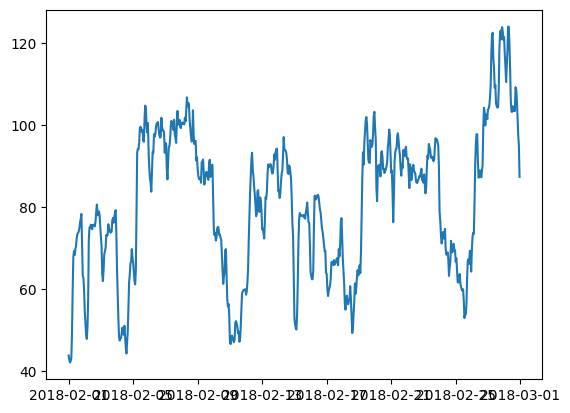

In [15]:
plt.plot(y['2018-02']);

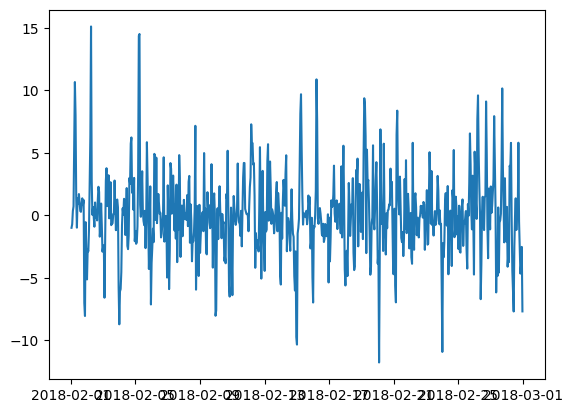

In [16]:
plt.plot(y['2018-02'].diff(1));

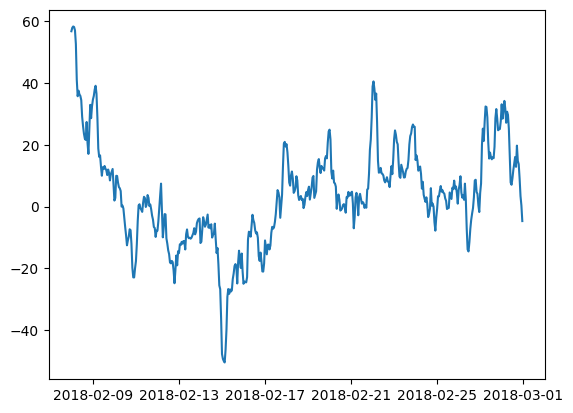

In [17]:
plt.plot(y['2018-02'].diff(24*7));

In [18]:
# custom function to plot autocorrelation
def plot_autocorrelation(y, d=0, D=0, m=0):
    y = pd.Series(y)
    if D > 0:
        for i in range(D):
            y = y.diff(m)
    if d > 0:
        for i in range(d):
            y = y.diff(1)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,2,3)
    ax3 = fig.add_subplot(2,2,4)
    ax1.plot(y)
    plot_acf(y, lags = 50, ax=ax2);
    plot_pacf(y, lags=50, method='ywm', ax=ax3, color='r');
    plt.show()

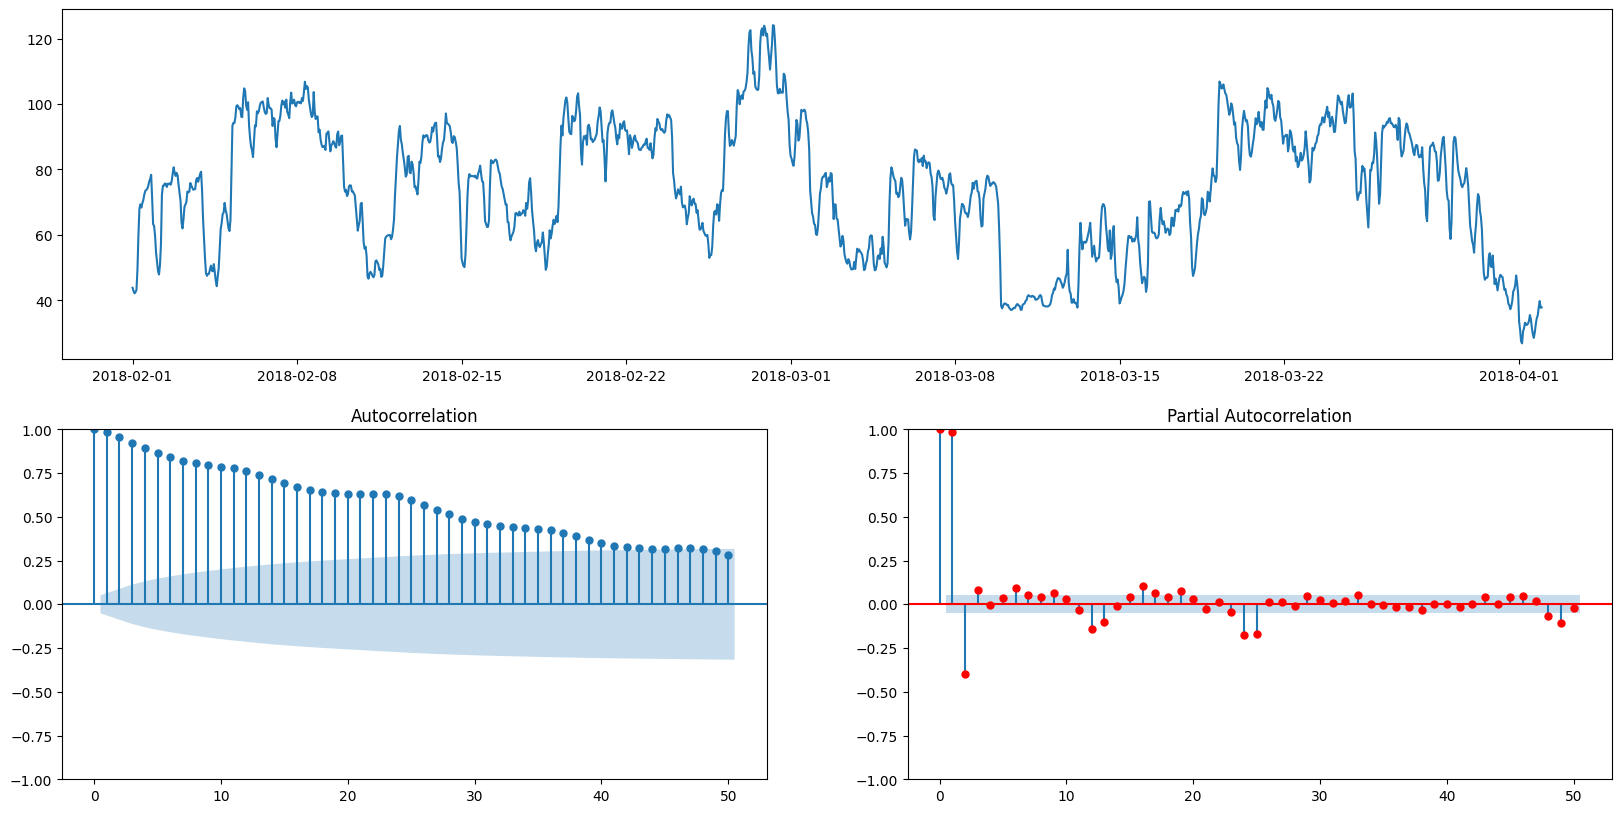

In [19]:
plot_autocorrelation(y_train['2018-02-01':'2018-04-01'], D=0, m=168)

## Fit the data using SARIMAX

In [20]:
import pmdarima as pm
sarimax = pm.auto_arima(y_train, exogenous=exog_train,
                           start_p=2, start_q=2,
                           test='adf',
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=None, D=None, trace=True,
                           suppress_warnings=True,
                           stepwise=False, n_jobs=-1, 
                           random=True, random_state=42)

/home/paularilo/.pyenv/versions/lewagon/lib/python3.10/site-packages/pmdarima/arima/_auto_solvers.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gen = random_state.permutation(list(gen))[:n_fits]


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [21]:
predict_48 = sarimax.predict(n_periods=48, exogenous=exog_test[:48])

NameError: name 'sarimax' is not defined

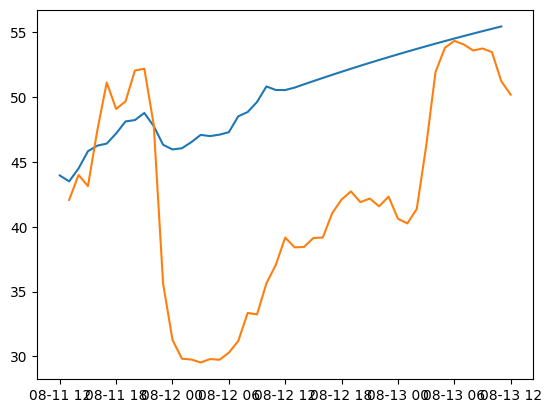

In [ ]:
plt.plot(predict_48, label='predict')
plt.plot(y_test[:48], label='real')

## Evaluate model

In [22]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
mean_absolute_percentage_error(y_test[:48], predict_48)

0.24031528216072903